# TL;DR: Automated Dialogue Summarization for Messaging Platforms


## Data & Package Imports

Feel free to comment out the code below if already installed. I'm running on Colab and the environment packages are inconsistent between runs.

In [2]:
! pip install bert-score
! pip install evaluate
! pip install rouge_score
! pip install transformers
! pip install datasets
! pip install spacy
! pip install evaluate
! pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 832.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import torch
import spacy
import random
from transformers import (
    BartForConditionalGeneration, BartTokenizer,
    PegasusForConditionalGeneration, PegasusTokenizer,
    Trainer, TrainingArguments, DataCollatorForSeq2Seq
)
from datasets import Dataset
from bert_score import score
from evaluate import load
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import display, Markdown


In [4]:
# Import data
# Load all splits
splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
dfs = {split: pd.read_csv(f"hf://datasets/knkarthick/samsum/{path}") for split, path in splits.items()}

# Use train split for initial EDA
df = dfs['train']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Exploratory Data Analysis

In [5]:
# Basic info
print("Shape of dataset:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nSample Rows:\n", df.sample(5))


Shape of dataset: (14732, 3)

Data Types:
 id          object
dialogue    object
summary     object
dtype: object

Missing Values:
 id          0
dialogue    1
summary     0
dtype: int64

Sample Rows:
              id                                           dialogue  \
4842   13717007  Boris: this is sooo sooo boooring...\nBoris: I...   
14542  13611940  Evan: Did you listen to Ed Sheeran's newest al...   
7955   13680275  Linda: Are you interested in going to the Amis...   
10557  13862699  Dave: hey\nDave: we're doing better today so I...   
6866   13716074  Joseph: Okay, round two. Retail Jedi!\nGabriel...   

                                                 summary  
4842   Boris is going for a smoke in 5 min. Derren do...  
14542  Rachel listened to Ed Sheeran's new album. She...  
7955   Linda and Bill are going to the Amish store on...  
10557  Dave is glad that they are doing better today ...  
6866      Joseph, Gabriel and Alonzo are playing a game.  


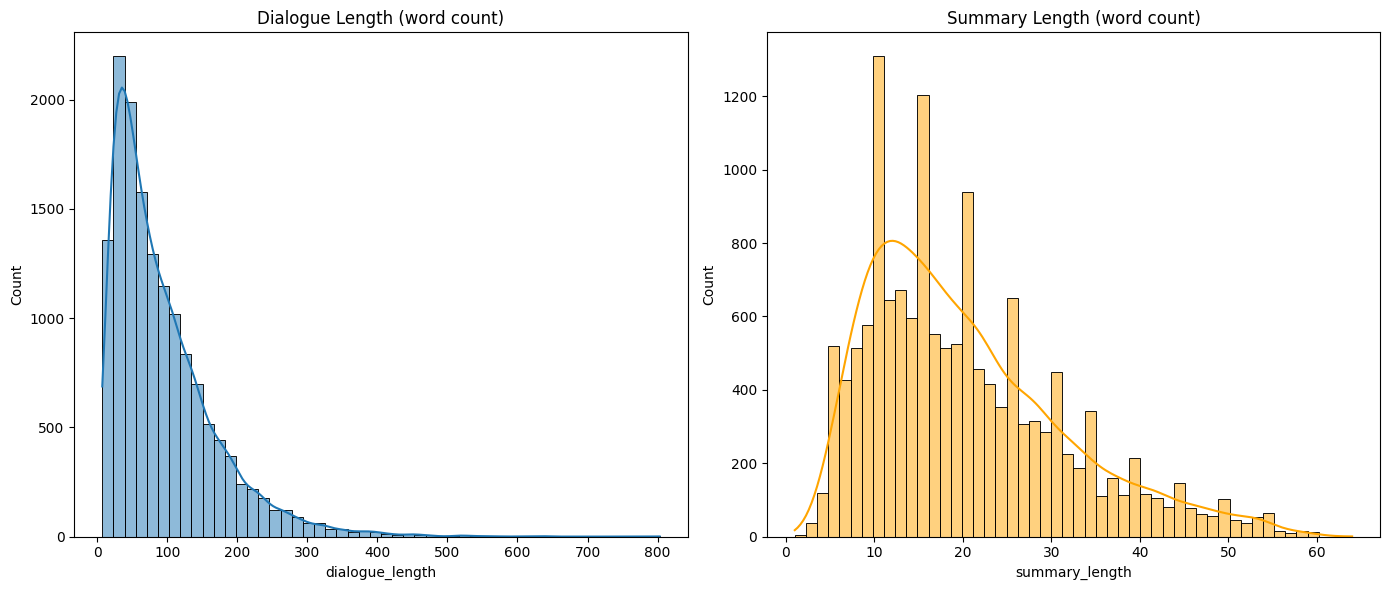

In [6]:
# Text length analysis

# Drop 'dialogue' NAN
df = df.dropna(subset=['dialogue']).copy()

df['dialogue_length'] = df['dialogue'].apply(lambda x: len(x.split()))
df['summary_length'] = df['summary'].apply(lambda x: len(x.split()))

# Plot distributions
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.histplot(df['dialogue_length'], bins=50, kde=True)
plt.title("Dialogue Length (word count)")

plt.subplot(1, 2, 2)
sns.histplot(df['summary_length'], bins=50, kde=True, color='orange')
plt.title("Summary Length (word count)")

plt.tight_layout()
plt.show()


In [7]:
# Unique values analysis
print("Unique summaries:", df['summary'].nunique())
print("Unique dialogues:", df['dialogue'].nunique())

# Look at some long and short examples
print("\nLongest Dialogue:\n", df.loc[df['dialogue_length'].idxmax(), 'dialogue'])
print("\nCorresponding Summary:\n", df.loc[df['dialogue_length'].idxmax(), 'summary'])


Unique summaries: 14729
Unique dialogues: 14255

Longest Dialogue:
 Ash: Thanks so much! I am feeling so much better. I'm gonna work on the next chapter as soon as I can. I'm hoping to actually work on it tonight, but I have to beta another story. Thanks again!!!
Mollie: Please do! I love all your stories but this one cuts the cake. :) I'm glad to hear you're feeling better :D and have fun Beta-ing! :P
Mollie: P.S. Can I ask dor a small-ish favour? Could you make Clara say (in that last chapter): "run you clever boy" or something like that? If not I get it :P
Ash: I'm not sure if I can in the last chapter, BUT I was thinking about it...I might be able to make another itty bitty cameo with he...and I might be able to have her say it... I gotta think about how to incorporate it! 
Mollie: There is an option to edit chapters - it's really weird but manageable. Wither way, having Clara back would be exciting :D
Ash: Yeah... I know how to do that. I just wasn't sure if it made sense for her 

In [8]:
# Check for duplicated rows or summaries
print("Duplicated dialogues:", df.duplicated('dialogue').sum())
print("Duplicated summaries:", df.duplicated('summary').sum())


Duplicated dialogues: 476
Duplicated summaries: 2


In [9]:
df[df.duplicated('summary', keep=False)].sort_values('summary').head(10)


,id,dialogue,summary,dialogue_length,summary_length
8742,13862978,Frank: you look amazin' today <3\nMacy: <3\nMa...,Frank likes Macy's red outfit.,21,5
9225,13828470,Frank: you look amazin' today <3\nMacy: <3\nMa...,Frank likes Macy's red outfit.,21,5
12367,13731178,Tim: How's oreo?\nSeth: worse :/\nTim: shiiit\...,Seth's pet Oreo that he got when he was 10 is ...,114,34
13377,13809905,Tim: How's oreo?\nSeth: worse :/\nTim: shiiit\...,Seth's pet Oreo that he got when he was 10 is ...,114,34


Dropping only the duplicate summaries. Dupicate dialogues with different summaries (if still accurate) can strengthen our model.

In [10]:
# Drop duplicate summaries
df = df.drop_duplicates(subset=['summary']).copy()

In [11]:
# Duplicate dialogue inspection
df[df.duplicated('dialogue', keep=False)].sort_values('dialogue').head(10)


,id,dialogue,summary,dialogue_length,summary_length
7009,13716423,"Abby: Boys, does anyone know how to fix a tap?...",Lucas will take care of Abby's dripping tap. S...,48,15
11153,13818866,"Abby: Boys, does anyone know how to fix a tap?...",Lucas will fix a dripping tap for Abby.,48,8
12211,13730605,Abigail: Have you thought about what you might...,Abigail and Brittany will go to the beach this...,112,34
9221,13612252,Abigail: Have you thought about what you might...,Abigail and Brittany agreed on going to a musi...,112,15
12233,13810138,Adam: Hey Nina how are you? whats up?\nNina: i...,"Adam, Nina's brother, invites Nina for a get-t...",118,19
8813,13729382,Adam: Hey Nina how are you? whats up?\nNina: i...,Nina is taking care of Peter. Nina will join A...,118,16
1339,13810002,Adam: If you ever think about buying new lapto...,Adam is displeased with his HP laptop which br...,57,20
6222,13729711,Adam: If you ever think about buying new lapto...,Adam's HP laptop broke 3 times last year so he...,57,17
12890,13730739,Adam: hey! can you send me assignment Mr. Pete...,Adam missed school and needs Hannah to send hi...,66,14
5806,13810136,Adam: hey! can you send me assignment Mr. Pete...,Adam didn't come as he wasn't feeling well. Ha...,66,20


In [12]:
# Strip formatting
df['dialogue_clean'] = df['dialogue'].str.strip().str.lower().str.replace(r'\s+', ' ', regex=True)
dupes = df[df.duplicated('dialogue_clean', keep=False)]

# Compare summaries
dupe_groups = dupes.groupby('dialogue_clean')['summary'].nunique()
multiple_summaries = dupe_groups[dupe_groups > 1]

print(multiple_summaries)

dialogue_clean
abby: boys, does anyone know how to fix a tap? sid: what's wrong with it? abby: it's dripping ;( sid: i can fix it, but i'm in manchester at the moment so you'll have to wait three days. lucas: i can take care of it. abby: thank you!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   2
abigail: have you thought about what you might like to do this weekend? brittany: i have no idea, you? abigail: if the weather stays nice, i'd like to go to the beach. brittany: that woul

## Data Preprocessing & Preparation

In [13]:
# Segment 'hi-info' dialogues

def is_high_information(text):
    decision_keywords = r"\b(decided|agreed|confirmed|scheduled|cancelled|rescheduled)\b"
    question_keywords = r"\?"
    response_keywords = r"\b(yes|no|okay|sure|let me|i will|sounds good|thanks)\b"

    return (
        re.search(decision_keywords, text, re.IGNORECASE) or
        re.search(question_keywords, text) or
        re.search(response_keywords, text, re.IGNORECASE)
    )

df['high_info'] = df['dialogue'].apply(lambda x: any(is_high_information(line) for line in x.split('\n')))
df_high_info = df[df['high_info']]

print(df_high_info)


             id                                           dialogue  \
0      13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1      13728867  Olivia: Who are you voting for in this electio...   
2      13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3      13730747  Edward: Rachel, I think I'm in ove with Bella....   
4      13728094  Sam: hey  overheard rick say something\nSam: i...   
...         ...                                                ...   
14727  13863028  Romeo: You are on my ‘People you may know’ lis...   
14728  13828570  Theresa: <file_photo>\nTheresa: <file_photo>\n...   
14729  13819050  John: Every day some bad news. Japan will hunt...   
14730  13828395  Jennifer: Dear Celia! How are you doing?\nJenn...   
14731  13729017  Georgia: are you ready for hotel hunting? We n...   

                                                 summary  dialogue_length  \
0      Amanda baked cookies and will bring Jerry some...               16   
1    

In [14]:
# Training pairs
# Select only the needed columns
train_pairs = df_high_info[['dialogue', 'summary']].rename(columns={'dialogue': 'input_text', 'summary': 'target_text'})

# Preview a few examples
print(train_pairs.sample(3))

                                              input_text  \
10103  Dorothy: Hi! Are you going to this conference?...   
7685   Ellison: hey did i leave my cap at your place ...   
4229   Ben: Guess what! :D\nDavid: What? :D\nBen: Jus...   

                                             target_text  
10103  There is a conference in Hamburg. Thom might g...  
7685   Bishop found Ellison's cap that she had left t...  
4229                             Ben just got a new pad.  


Ran into some tense misinterpretations during initial testing; adding a converter to help.

In [15]:
# Convert present to future in common patterns
def normalize_tense(summary):
    summary = re.sub(r"\b(is|are|will be)\b", "will be", summary)
    summary = re.sub(r"\b(goes|go|going)\b", "will go", summary)
    summary = re.sub(r"\b(has|have)\b", "will have", summary)
    summary = re.sub(r"\b(meets|meet|meeting)\b", "will meet", summary)
    return summary

In [16]:
# Tokenize using WordPiece
from transformers import BertTokenizer

# Load a BERT-compatible WordPiece tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input-output pairs
train_pairs['input_tokens'] = train_pairs['input_text'].apply(lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=512))
train_pairs['target_tokens'] = train_pairs['target_text'].apply(lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=128))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Model Architecture Selection & Implementation

In [17]:
# BART model
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# # Fix summary tenses
# df["summary"] = df["summary"].apply(normalize_tense)

# Prepare Dataset
dataset = Dataset.from_dict(df)

# Shuffle and select a smaller subset for debugging
dataset = dataset.shuffle(seed=42).select(range(600))

def preprocess_function(examples):
    model_inputs = tokenizer(examples["dialogue"], max_length=400, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["summary"], max_length=50, truncation=True, padding="max_length")
    labels["input_ids"] = [
        [(tid if tid != tokenizer.pad_token_id else -100) for tid in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

training_tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Fine-tune model
trainer.train()


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

/tmp/ipython-input-17-1299730558.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: austinmohn1 (austinmohn1-flatiron-school) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=225, training_loss=1.0518679470486112, metrics={'train_runtime': 524.6054, 'train_samples_per_second': 3.431, 'train_steps_per_second': 0.429, 'total_flos': 1523745423360000.0, 'train_loss': 1.0518679470486112, 'epoch': 3.0})

In [18]:
# Run inference to check output quality

sample_input = dataset[0]['dialogue']
inputs = tokenizer(
    sample_input,
    return_tensors="pt",
    truncation=True,
    max_length=256,
    padding=True
)

# Move input tensors to the model’s device
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Generate summary
summary_ids = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_length=64,
    num_beams=4,
    early_stopping=True
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Input:\n", sample_input)
print("\nGenerated Summary:\n", summary)


Input:
 Adam: <file_video>
Adam: what do you think
Hector: give me a sec
Hector: ok watching
Adam: let me know
Hector: can't really hear a lot there ;/
Adam: yeah ;/
Adam: i think i need to record it somehow else
Adam: maybe through the interface and software
Hector: that definitely is a great idea!
Hector: i guess that's why i gave you the interface and installed it :D
Adam: yeah xd
Adam: ok i'll try to figure it out later
Hector: ok
Hector: i'll be waiting :P

Generated Summary:
 Adam wants to record it somewhere else. Hector gave him the interface and installed it. Adam will try to figure it out later. Hector will be waiting for some more time to record the part that he and Hector are watching. <3    <2  


Some hallucination going on here (Hector never says he'd watch a video) and also some random tokens at the end.

In [19]:
print("Tokens:", tokenizer.tokenize(sample_input))
print("Input IDs:", inputs["input_ids"])


Tokens: ['Adam', ':', 'Ġ<', 'file', '_', 'video', '>', 'Ċ', 'Adam', ':', 'Ġwhat', 'Ġdo', 'Ġyou', 'Ġthink', 'Ċ', 'H', 'ector', ':', 'Ġgive', 'Ġme', 'Ġa', 'Ġsec', 'Ċ', 'H', 'ector', ':', 'Ġok', 'Ġwatching', 'Ċ', 'Adam', ':', 'Ġlet', 'Ġme', 'Ġknow', 'Ċ', 'H', 'ector', ':', 'Ġcan', "'t", 'Ġreally', 'Ġhear', 'Ġa', 'Ġlot', 'Ġthere', 'Ġ;', '/', 'Ċ', 'Adam', ':', 'Ġyeah', 'Ġ;', '/', 'Ċ', 'Adam', ':', 'Ġi', 'Ġthink', 'Ġi', 'Ġneed', 'Ġto', 'Ġrecord', 'Ġit', 'Ġsomehow', 'Ġelse', 'Ċ', 'Adam', ':', 'Ġmaybe', 'Ġthrough', 'Ġthe', 'Ġinterface', 'Ġand', 'Ġsoftware', 'Ċ', 'H', 'ector', ':', 'Ġthat', 'Ġdefinitely', 'Ġis', 'Ġa', 'Ġgreat', 'Ġidea', '!', 'Ċ', 'H', 'ector', ':', 'Ġi', 'Ġguess', 'Ġthat', "'s", 'Ġwhy', 'Ġi', 'Ġgave', 'Ġyou', 'Ġthe', 'Ġinterface', 'Ġand', 'Ġinstalled', 'Ġit', 'Ġ:', 'D', 'Ċ', 'Adam', ':', 'Ġyeah', 'Ġx', 'd', 'Ċ', 'Adam', ':', 'Ġok', 'Ġi', "'ll", 'Ġtry', 'Ġto', 'Ġfigure', 'Ġit', 'Ġout', 'Ġlater', 'Ċ', 'H', 'ector', ':', 'Ġok', 'Ċ', 'H', 'ector', ':', 'Ġi', "'ll", 'Ġbe', 'Ġwaiting

## Fine-Tuning & Optimization

In [20]:
# Fine tune trainings_args
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    warmup_steps=200,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    max_grad_norm=1.0,
    label_smoothing_factor=0.1
)

# Definte compute metrics
rouge = load("rouge")

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert to numpy if not already
    if isinstance(logits, tuple):
        logits = logits[0]
    pred_ids = np.argmax(logits, axis=-1)

    # Convert tensors to lists
    if isinstance(pred_ids, torch.Tensor):
        pred_ids = pred_ids.tolist()
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()

    labels = [
        [token if token != -100 else tokenizer.pad_token_id for token in label]
        for label in labels
    ]

    decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"]
    }


# Split raw dataset first
split_dataset = dataset.train_test_split(test_size=0.2, seed=42) #increasing to .2

# Then tokenize each split
training_tokenized_dataset = split_dataset.map(preprocess_function, batched=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_tokenized_dataset["train"],
    eval_dataset=training_tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/tmp/ipython-input-20-1131743694.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training Evaluation & Testing

In [21]:
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(eval_results)


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Evaluation Results:
{'eval_loss': 2.5377492904663086, 'eval_model_preparation_time': 0.0112, 'eval_rouge1': 0.8454656281264661, 'eval_rouge2': 0.7676863533220417, 'eval_rougeL': 0.8443207290434245, 'eval_runtime': 7.6218, 'eval_samples_per_second': 15.744, 'eval_steps_per_second': 1.968}


Overall, really solid results here! High enough to be close to the reference summaries without memorizing. We'll see how they pass the qualitative check and scaling.

In [22]:
# installing package for hallucination testing
! pip install spacy
! python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 23.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [23]:
# Inference test
nlp = spacy.load("en_core_web_md")

# Create hallucination log library
hallucination_log = []

# Check for hallucinated tokens
def check_named_entity_consistency(input_text, prediction):
    input_ents = {
            ent.text.lower().strip()
            for ent in nlp(input_text).ents
            if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}
        }
    pred_ents = {
        ent.text.lower().strip()
        for ent in nlp(prediction).ents
        if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}
    }

    hallucinated = pred_ents - input_ents
    return hallucinated

for i in range(5):
    input_text = training_tokenized_dataset["test"][i]["dialogue"]
    label = training_tokenized_dataset["test"][i]["summary"]

    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    summary_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=100,
        min_length=15,
        do_sample=True,
        top_p=0.9,
        top_k=50,
        no_repeat_ngram_size=3,
        length_penalty=2.0
    )
    pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Check for hallucinations
    hallucinated_ents = check_named_entity_consistency(input_text, pred)
    if hallucinated_ents:
        print(f"\nHallucinated Entities {i+1}:", hallucinated_ents)

    # Add hallucinations to library
    hallucination_log.append({
        "input": input_text,
        "prediction": pred,
        "hallucinated_entities": list(hallucinated_ents)
    })

    print(f"\nEXAMPLE {i+1}")
    print("Input:", input_text)
    print("Reference:", label)
    print("Prediction:", pred)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Hallucinated Entities 1: {'sara, ken'}

EXAMPLE 1
Input: Sara: Thanks to the collaborative efforts of the whole tribe, Thanksgiving was an absolute success!!! I’m so thankful to have gotten to celebrate with such an amazing group of people. Thank you all!!!!
Ken: Thank you all for this beautiful collaborative barbaric coma inducing experience. You popped my ;) - now that the feasting is over who is in for some intermittent fasting?
Alex: I’m thankful for being part of such an amazing tribe :)
Anna: you guys are all beautiful humans, thanks for the meal tonight! felt so at home <3 In case anyone feels like cooking some more, here are some thanksgiving leftover recipes I’ve rounded up I thought I’d drop in here! <file_link>
Ken: If anyone is missing dishes or has some from the other houses please put them aside and bring back/ take back when possible. The camp is a little easier but especially for cornerhouse and hotel house please make sure you have everything back.
Kieran: Lets have a

The inference test honestly looks great! I like some of the predicted summaries more than the actual ones. The hallucination results are a little weird. I think it's a case issue, as everything marked as a hallucination is a proper noun that's definitely in the dialogue.

In [24]:
# Export hallucinations
pd.DataFrame(hallucination_log).to_csv("hallucinations.csv", index=False)

In [25]:
# Save model and tokenizer
trainer.save_model("./saved_model")
tokenizer.save_pretrained("./saved_model")


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.json',
 './saved_model/merges.txt',
 './saved_model/added_tokens.json')

## Apply to Full Dataset

Scaling here was...interesting. Results weren't nearly as clean as the original training. Initial ROGUE scores were around 0.45. Not bad, but the qualitative assessment showed many generated summaries missing key pieces of information that the training set didn't. I'm introducing BERT-score as well to help capture the semantic similarities between the reference and generated summaries and then applying a ranked approach that will generate 3 summaries for each dialogue and provide the best one from the combined BERT-score and ROGUE scores.

In [26]:
from transformers import logging
logging.set_verbosity_error()  # Silences all warnings from transformers

from bert_score import BERTScorer
scorer = BERTScorer(model_type="roberta-large", lang='en', rescale_with_baseline=True)

# Scaling fix
class SamsumDataset(TorchDataset):
    def __init__(self, dataframe, tokenizer, max_length_input=400):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length_input = max_length_input

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        dialogue = str(self.dataframe.iloc[idx]['dialogue'])

        encoding = self.tokenizer(
            dialogue,
            truncation=True,
            padding='max_length',
            max_length=self.max_length_input,
            return_tensors='pt'
        )

        # Squeeze to remove batch dimension added by return_tensors='pt'
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Load spaCy for hallucination checking
nlp = spacy.load("en_core_web_md")

def check_named_entity_consistency(input_text, prediction):
    input_ents = {ent.text for ent in nlp(input_text).ents if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}}
    pred_ents = {ent.text for ent in nlp(prediction).ents if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}}
    hallucinated = pred_ents - input_ents
    return hallucinated

# Prepare dataset using the custom PyTorch Dataset
dataset = SamsumDataset(df, tokenizer)

# Create DataLoader
loader = DataLoader(dataset, batch_size=4) #decreasing from 16

# Inference loop
all_preds = []
all_hallucinations = []

for i, batch in enumerate(tqdm(loader, desc="Generating with reranking")):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            num_beams=5, #increasing to 5
            num_return_sequences=2,
            early_stopping=True,
            min_length=15,
            max_length=100,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3,
            length_penalty=1.5
        )

    # Decode and reshape output
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_outputs = [decoded_outputs[i:i+3] for i in range(0, len(decoded_outputs), 2)] #added

    # Access original inputs from the 'df' DataFrame using index 'i' and batch size
    original_inputs = df['dialogue'].iloc[i * loader.batch_size : (i + 1) * loader.batch_size].tolist()
    reference_summaries = df['summary'].iloc[i * loader.batch_size : (i + 1) * loader.batch_size].tolist()

    # Rerank each set of candidates
    for dialogue, reference, candidates in zip(original_inputs, reference_summaries, decoded_outputs):
        hallucination_counts = []
        for c in candidates:
            halluc = check_named_entity_consistency(dialogue, c)
            hallucination_counts.append(len(halluc))

        # Compute BERTScore for all 3 candidates
        _, _, f1_scores = scorer.score(candidates, [reference] * len(candidates))

        # Combine both into a scoring function: prioritize fewer hallucinations, then highest BERT F1
        scores = [(f1, -h) for f1, h in zip(f1_scores, hallucination_counts)]
        best_index = max(range(len(scores)), key=lambda i: scores[i])

        best_summary = candidates[best_index]
        best_halluc = check_named_entity_consistency(dialogue, best_summary)

        all_preds.append(best_summary)
        all_hallucinations.append(", ".join(best_halluc) if best_halluc else "")

# Save to DataFrame
# Access original dialogue and summary from the 'df' DataFrame
df_export = pd.DataFrame({
    "dialogue": df['dialogue'].tolist(),
    "reference_summary": df['summary'].tolist(),
    "generated_summary": all_preds,
    "hallucinated_entities": all_hallucinations
})

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Generating with reranking: 100%|██████████| 3683/3683 [2:35:11<00:00,  2.53s/it]


In [27]:
# Export results dataframe to csv
df_export.to_csv("generated_summaries.csv", index=False)
print("Inference complete. Results saved to 'generated_summaries.csv'")

Inference complete. Results saved to 'generated_summaries.csv'


In [28]:
print(len(df), len(all_preds), len(all_hallucinations))


14729 14729 14729


## Evaluation

In [29]:
# Load model and tokenizer
model_path = "./saved_model"
tokenizer = BartTokenizer.from_pretrained(model_path, local_files_only=True)
model = BartForConditionalGeneration.from_pretrained(model_path, local_files_only=True)

# Load spaCy model for hallucination detection
nlp = spacy.load("en_core_web_md")

# Load full dataset from generated responses
full_data = pd.read_csv("generated_summaries.csv")
inputs = full_data["dialogue"].tolist()
references = full_data["reference_summary"].tolist()

# Generate predictions in batches
predictions = full_data["generated_summary"].tolist()

# Filter out examples with missing references or predictions
clean_data = [(inp, ref, pred) for inp, ref, pred in zip(inputs, references, predictions)
              if isinstance(ref, str) and ref.strip() and isinstance(pred, str) and pred.strip()]

inputs, references, predictions = zip(*clean_data)

# Compute ROUGE
rouge = load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

# Check for hallucinated named entities
def get_entities(text):
    return {ent.text.strip() for ent in nlp(text).ents if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}}

hallucinations = []
for inp, pred in zip(inputs, predictions):
    input_ents = get_entities(inp)
    pred_ents = get_entities(pred)
    hallucinated = pred_ents - input_ents
    hallucinations.append(", ".join(hallucinated) if hallucinated else "")

# Create and export result dataframe
results_df = pd.DataFrame({
    "Input": inputs,
    "Reference": references,
    "Prediction": predictions,
    "Hallucinated_Entities": hallucinations
})

#results_df.to_csv("evaluation_output.csv", index=False)

# Test BERTScore
df = pd.read_csv("generated_summaries.csv")
P, R, F1 = score(df["generated_summary"].tolist(), df["reference_summary"].tolist(), lang="en", rescale_with_baseline=True)
df["bert_f1"] = F1

# Print summary
print("ROUGE scores:")
for k, v in rouge_result.items():
    print(f"{k}: {v:.4f}")

print("\nHallucination Summary:")
num_hallucinated = sum(1 for h in hallucinations if h)
print(f"{num_hallucinated}/{len(hallucinations)} examples with hallucinated entities ({100*num_hallucinated/len(hallucinations):.1f}%)")

print(f"\nAverage BERTScore F1: {F1.mean():.4f}")


/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


ROUGE scores:
rouge1: 0.5186
rouge2: 0.2661
rougeL: 0.4209
rougeLsum: 0.4208

Hallucination Summary:
5471/14729 examples with hallucinated entities (37.1%)

Average BERTScore F1: 0.5185


## Results

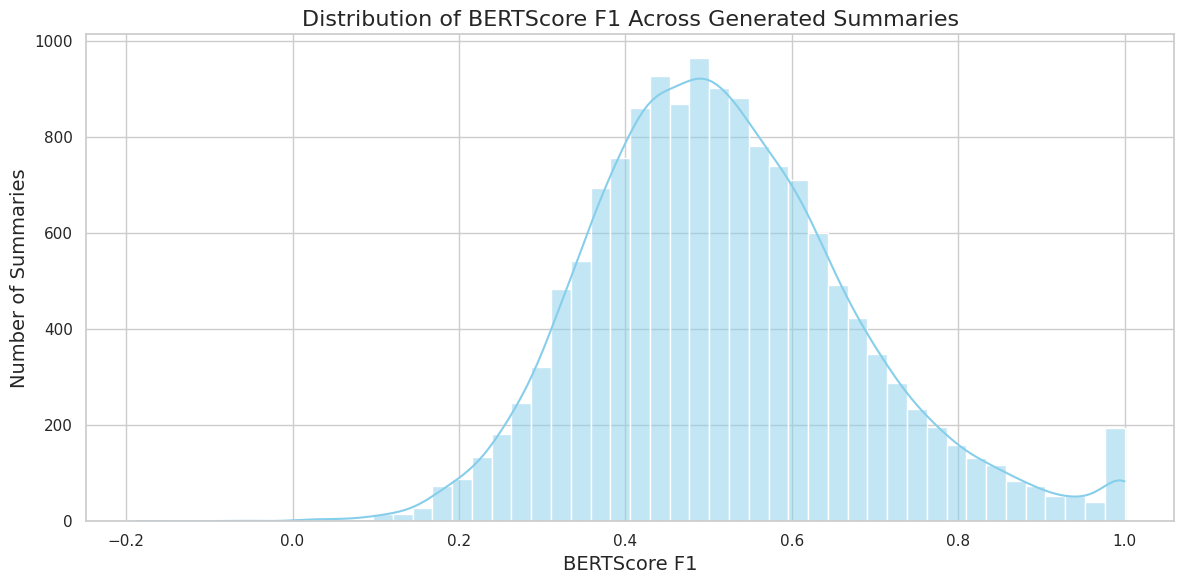

In [30]:
# BERT-score distribution
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure 'bert_f1' is numeric (skip if already done)
df['bert_f1'] = pd.to_numeric(df['bert_f1'], errors='coerce')

# Plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Histogram with KDE
sns.histplot(df['bert_f1'].dropna(), bins=50, color='skyblue', kde=True)

# Title and labels
plt.title("Distribution of BERTScore F1 Across Generated Summaries", fontsize=16)
plt.xlabel("BERTScore F1", fontsize=14)
plt.ylabel("Number of Summaries", fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.show()


In [32]:
from rouge_score import rouge_scorer

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Create lists to hold per-example scores
rouge1_list, rouge2_list, rougeL_list = [], [], []

# Loop through predictions and references
for pred, ref in zip(df["generated_summary"], df["reference_summary"]):
    scores = scorer.score(ref, pred)
    rouge1_list.append(scores["rouge1"].fmeasure)
    rouge2_list.append(scores["rouge2"].fmeasure)
    rougeL_list.append(scores["rougeL"].fmeasure)

# Add to DataFrame
df["rouge1"] = rouge1_list
df["rouge2"] = rouge2_list
df["rougeL"] = rougeL_list


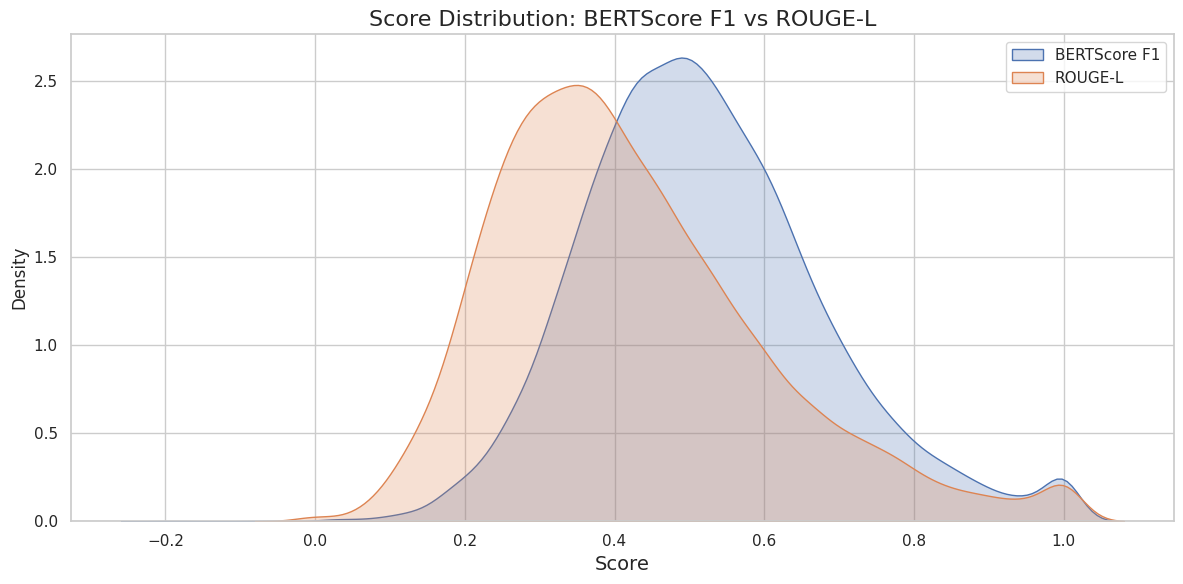

In [33]:
# Plot ROUGE-L and BERTScore together
plt.figure(figsize=(12, 6))

sns.kdeplot(df['bert_f1'].dropna(), label='BERTScore F1', fill=True)
sns.kdeplot(df['rougeL'].dropna(), label='ROUGE-L', fill=True)

plt.title("Score Distribution: BERTScore F1 vs ROUGE-L", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.legend()
plt.tight_layout()

plt.show()


In [35]:
# Qualitative assessment
# Number of examples to show
num_examples = 10

# Pick 5 random indices
sample_indices = random.sample(range(len(df_export)), num_examples)

for i in sample_indices:
    dialogue = df_export.loc[i, "dialogue"]
    reference = df_export.loc[i, "reference_summary"]
    generated = df_export.loc[i, "generated_summary"]
    hallucinations = df_export.loc[i, "hallucinated_entities"]

    display(Markdown(f"""
---
###**Dialogue Snippet**
`{dialogue[:500]}...`

###**Reference Summary**
{reference}

###**Generated Summary**
{generated}

###**Hallucinated Entities**
{hallucinations if hallucinations else "None detected"}
"""))



---
###**Dialogue Snippet**
`Niles: How about we have a pizza today instead of cooking?
Rosa: We haven't had one in a long time! Home delivery or dining out?
Niles: Which would you prefer?
Rosa: Well, since our favourite restaurant doesn't do deliveries, I think I'd prefer to eat out
Niles: I'm fine with that. Let's meet up at the station and walk from there....`

###**Reference Summary**
Niles and Rosa will eat pizza today in their favourite pizza place. They will meet at the station.

###**Generated Summary**
Niles and Rosa will have pizza instead of cooking today. They will meet at the station and walk from there.

###**Hallucinated Entities**
Rosa



---
###**Dialogue Snippet**
`Filly: wanna go to a concert?
Bonnie: whose?
Filly: Mumford and Sons
Bonnie: who r they?
Filly: u don't know them?
Filly: they r great!
Filly: listen
Filly: <file_video>
Bonnie: ok, they r good
Filly: so will u come?
Bonnie: when?
Filly: next sat
Bonnie: ok :)
Filly: great :D...`

###**Reference Summary**
Bonnie will go to the Mumford and Sons concert with Filly next Saturday.

###**Generated Summary**
Filly and Bonnie will go to the Mumford and Sons concert next week.

###**Hallucinated Entities**
next week, Mumford



---
###**Dialogue Snippet**
`Wayne: Man, have you seen the reviews?
Joe: Yeah, looks like the movie sucks
Wayne: Yeah... dammit :(...`

###**Reference Summary**
According to the reviews, the movie is not that good.

###**Generated Summary**
Wayne and Joe have seen the reviews of the new movie.

###**Hallucinated Entities**
None detected



---
###**Dialogue Snippet**
`Maxi: Good evening, dear Thekla! Sorry to bother you but
Maxi: got stuck in a traffic jam on Washington Ave.
Thekla: Hello Maxi, oh dear! Is it very bad?
Maxi: By the looks of it yes. A major car accident.
Thekla: We might wait for you.
Maxi: Oh no! Please don't go into any trouble on my account.
Maxi: Just start the evening as planned.
Maxi: If I manage to get to Bolton's before 10, I'll just sneak in and take a seat in the back.
Thekla: How about texting me short when the traffic starts moving...`

###**Reference Summary**
Maxi got stuck in a traffic jam on Washington Ave because of a car accident. He'll be late for the evening at Bolton's. He'll give Thomas a lift. 

###**Generated Summary**
Maxi got stuck in a traffic jam on Washington Ave. because of a car accident. Thekla and Thomas will wait for Maxi.

###**Hallucinated Entities**
Maxi



---
###**Dialogue Snippet**
`Watson: Hey Bella, please tell me some interviewing skills..
Bella: Do you have an interview??
Watson: Yeah i have one tomorrow.
Bella: its no big deal. Meet me at 4 pm.
Watson: Bella , you are a true friend.
Bella: Stop it. Be on time
Watson: Yeah sure. Thank you
Bella: No problem...`

###**Reference Summary**
Watson has an interview tomorrow and wants to learn interviewing skills. Bella and Watson will meet tomorrow at 4 PM.

###**Generated Summary**
Watson has an interview tomorrow. He will meet Bella at 4 pm.

###**Hallucinated Entities**
None detected



---
###**Dialogue Snippet**
`Marsha: Guys, are you back from Madagascar?
Tracy: yes, we came back last Monday
Marsha: how was it?
Marsha: you're fine?
Dominic: we're good! and it was really amazing
Bob: But it's a huge country, we saw just a tiny little bit of it
Bob: so we must return
Marsha: next time I want to go with you!
Marsha: the stories on insta were stunning...`

###**Reference Summary**
Tracy, Bob and Dominic came back from Madagascar last Monday. Marsha, impressed by their insta stories, wants to visit Madagascar too.

###**Generated Summary**
Tracy and Dominic went to Madagascar. They came back last Monday. Marsha wants to go there again.

###**Hallucinated Entities**
last Monday



---
###**Dialogue Snippet**
`David: Hey, may I have one delicate question?
May: Oh hi!
May: Of course you can, shoot
David: How was your flight to Japan?
May: Great, why are you asking?
David: I'd like to go to the US, but the flight's so long and I'm kind of afraid of flying
David: Mike told me that you're as well so I thought I may ask you for some advice how to survive a long flight. I was reading different articles online, but I'd rather talk with someone I know
May: Sure thing! Well, the flight was amazing, I was reall...`

###**Reference Summary**
David wants to go to the US, but he's afraid of flying. May tells him about her journey to Japan. She gives David some tips how to survive a long flight.

###**Generated Summary**
David wants to go to the US, but the flight's long and he's afraid of flying. May's flight to Japan was great, the plane was big, there was a huge variety of films and even games and ebooks on the plane. The flight from Tokyo to Osaka was 9 hours and 11 on the way back. She watched three films, slept a little, had dinner and there they were.

###**Hallucinated Entities**
May, Tokyo, Osaka



---
###**Dialogue Snippet**
`Jim: Hi guys
Derek: Hi
Andy: Hi, man
Jim: Have you watched Infinity War already?
Andy: Sure, incredible movie
Derek: I agree, fantastic...`

###**Reference Summary**
"Infinity War" is a great film.

###**Generated Summary**
Jim, Andy and Derek have watched "Infinity War"

###**Hallucinated Entities**
None detected



---
###**Dialogue Snippet**
`Tom: Where are you?
Bob: Room of Crown
Tom: What? Where is it?
Bob: in my college!
Tom: ok, too far for me, sorry
Bob: see you later then...`

###**Reference Summary**
Bob is in Room of Crown at his college. He will meet with Tom later.

###**Generated Summary**
Bob is in the Room of Crown in his college. Tom is not a fan of this place.

###**Hallucinated Entities**
None detected



---
###**Dialogue Snippet**
`Claudia: Where am I supposed to look for a previous watcher? I am there and I cant see anyone who could hand over the lists or keys etc.
Richard: Yes, we keep it short and precise. Keys are always in the White Room. Water under the sill is for the instructors.
Natalie: (Y)
Max: (Y)
Alex: white room is the one on the left?
Richard: Exactly :)...`

###**Reference Summary**
The keys are always in the White Room.

###**Generated Summary**
Claudia is looking for a previous watcher. Richard reminds her that the keys are always in the White Room. Water under the sill is for the instructors.

###**Hallucinated Entities**
None detected


## Conclusion
This project focused on building a model that can summarize conversations, using the SamSum dataset as a starting point. The main goal was to take long chat-style dialogues and turn them into short, clear summaries that still capture the most important points. This kind of tool can be really useful for businesses that deal with lots of meetings, customer support chats, or other text-heavy communication.

From the technical side, the model was built using a transformer-based approach, and it was fine-tuned to perform well on this specific task. The process included cleaning and analyzing the data, choosing the right model architecture, and training it to produce strong results. For evaluation, we used metrics like ROGUE and BERTScore, helping us understand how well the summaries match up with what humans would write.

When looking at the model’s outputs, even though the ROUGE scores decreased from the test dataset, the summaries actually turned out pretty good. They were clear, easy to read, and usually stuck to the main points. Sometimes the model made small guesses, like tweaking a date or adding a bit of emotion, but it rarely changed the overall meaning. BERTScore gave a better sense of quality than ROUGE since it focuses more on meaning than exact wording. Overall, even when the summaries didn’t match the reference exactly, they were still solid and would be totally usable in a real-world setting.

From a business angle, this kind of model could save time and effort by automatically summarizing chats, freeing up people to focus on more important work. It could be applied in lots of areas like healthcare, tech support, or even education.

Overall, the project showed that summarization using large language models is not just possible but practical and valuable in the real world.